In [76]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from catboost import CatBoostRegressor
from tqdm import tqdm

warnings.filterwarnings('ignore')

train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
sample_submission = pd.read_csv("./data/sample_submission.csv")
age_gender_info = pd.read_csv("./data/age_gender_info.csv")
age_gender_spec = pd.DataFrame(age_gender_info['지역'])
population = pd.read_csv('./data/population.csv')
population.columns = ['지역','인구수']
age_gender_spec['2050'] = age_gender_info[['20대(남자)','20대(여자)','30대(남자)','30대(여자)',
                                          '40대(남자)','40대(여자)', '50대(남자)', '50대(여자)']].sum(axis=1)
age_gender_spec['5070'] = age_gender_info[['50대(남자)','50대(여자)',
                                          '60대(남자)','60대(여자)','70대(남자)','70대(여자)']].sum(axis=1)
age_gender_spec = age_gender_spec.merge(population, on='지역')
# age_gender_spec['4050'] = age_gender_info[['40대(남자)','40대(여자)','50대(남자)','50대(여자)']].sum(axis=1)
# age_gender_spec['6070'] = age_gender_info[['60대(남자)','60대(여자)','70대(남자)','70대(여자)']].sum(axis=1)
plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)

train.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수', '등록차량수'
]

test.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수'
]

categorial_variable = ["임대건물구분", "지역", "공급유형", "자격유형"]
continious_variable = ["총세대수", "전용면적", "전용면적별세대수", "공가수", "임대보증금", "임대료",
                       "단지내주차면수"]



# test_x_unique
# gbr: 72.57647194273466
# rfr: 19.73668358714044
# {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 16, 'n_estimators': 100} -62.07652539964124
# 144.17 143.65

In [77]:
def sorter(column):
    test_index = pd.Categorical(column,categories=pd.unique(test['단지코드']),ordered=True)
    return pd.Series(test_index)


def pre_processing(x, flag):
    x = x.fillna(0)
    x.loc[x['임대료'] == '-', ['임대료']] = 0
    x.loc[x['임대보증금'] == '-', ['임대보증금']] = 0
    x[['임대료', '임대보증금']] = x[['임대료', '임대보증금']].astype('int64')

    x['전용면적'] = x['전용면적'] // 5 * 5
    idx = x[x['전용면적'] > 100].index
    x.loc[idx, '전용면적'] = 100
    idx = x[x['전용면적'] < 15].index
    x.loc[idx, '전용면적'] = 15
    columns = ['단지코드', '총세대수', '공가수', '지역', '단지내주차면수', '지하철', '버스', '공급유형', '임대건물구분', '자격유형']
    target = "등록차량수"
    area_columns = []
    for area in x['전용면적'].unique():
        area_columns.append(f'면적_{area}')

    new_x = pd.DataFrame()
    for i, code in tqdm(enumerate(x['단지코드'].unique())):
        temp = x[x['단지코드'] == code]
        temp.index = range(temp.shape[0])
        for col in columns:
            new_x.loc[i, col] = temp.loc[0, col]

        for col in area_columns:
            area = float(col.split('_')[-1])
            new_x.loc[i, col] = temp[temp['전용면적'] == area]['전용면적별세대수'].sum()

        if flag == True:
            new_x.loc[i, '등록차량수'] = temp.loc[0, '등록차량수']
    
    new_x = new_x.merge(age_gender_spec[['지역','2050']], on='지역', sort=False)
    new_x = pd.get_dummies(new_x, columns=categorial_variable)
    new_x = new_x[[c for c in new_x if c not in ['등록차량수']] + [c for c in ['등록차량수'] if c in new_x]]
    # scaler = RobustScaler()
    # x[continious_variable] = scaler.fit_transform(x[continious_variable])
    return new_x

differ_variables = ['공급유형_공공임대(5년)', '공급유형_공공임대(10년)', '자격유형_B', '자격유형_F',
                    '지역_서울특별시', '공급유형_공공분양', '공급유형_장기전세', '자격유형_D',
                    '면적_65.0']

if len(test[test['자격유형'].isnull() == True]) > 0:
    test.loc[test['자격유형'].isnull() == True, ['자격유형']] = ('A', 'C')

new_train = pre_processing(train, True)
new_test = pre_processing(test, False)


423it [00:06, 61.02it/s]
150it [00:02, 68.51it/s]


In [78]:
new_test = new_test.sort_values(by="단지코드", key=sorter)
for c in differ_variables:
    new_test[c] = 0

x_train = new_train.iloc[:, 1:-1]
y_train = new_train.iloc[:, -1]
x_test = new_test.iloc[:, 1:]

rfr = RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_leaf=1,
                            min_samples_split=4, random_state=46)
cbr = CatBoostRegressor(loss_function='MAE', random_state=44)
model = cbr
train_X, test_X, train_y, test_y = train_test_split(x_train, y_train, test_size=0.2, random_state=93)

new_test

,단지코드,총세대수,공가수,단지내주차면수,지하철,버스,면적_35.0,면적_45.0,면적_50.0,면적_30.0,...,자격유형_M,자격유형_N,공급유형_공공임대(5년),자격유형_B,자격유형_F,지역_서울특별시,공급유형_공공분양,공급유형_장기전세,자격유형_D,면적_65.0
0,C1072,754.0,14.0,683.0,0.0,2.0,116.0,262.0,376.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,C1128,1354.0,9.0,1216.0,0.0,3.0,420.0,356.0,578.0,0.0,...,0,0,0,0,0,0,0,0,0,0
36,C1456,619.0,18.0,547.0,0.0,16.0,165.0,196.0,132.0,82.0,...,0,0,0,0,0,0,0,0,0,0
44,C1840,593.0,7.0,543.0,0.0,3.0,335.0,174.0,84.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,C1332,1297.0,11.0,1112.0,0.0,2.0,425.0,568.0,304.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,C2456,349.0,17.0,270.0,0.0,4.0,138.0,96.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
129,C1266,596.0,35.0,593.0,0.0,1.0,304.0,107.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
98,C2152,120.0,9.0,40.0,0.0,1.0,0.0,0.0,0.0,54.0,...,0,0,0,0,0,0,0,0,0,0
66,C1267,675.0,38.0,467.0,0.0,1.0,126.0,180.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
model.fit(train_X, train_y)
pred = model.predict(test_X)
print(mean_absolute_error(test_y, pred))


0:	learn: 274.9194370	total: 2.09ms	remaining: 2.09s
1:	learn: 269.6271033	total: 4.2ms	remaining: 2.1s
2:	learn: 264.4404674	total: 6.05ms	remaining: 2.01s
3:	learn: 260.3084657	total: 7.76ms	remaining: 1.93s
4:	learn: 255.3975554	total: 9.43ms	remaining: 1.88s
5:	learn: 250.9198116	total: 11.1ms	remaining: 1.84s
6:	learn: 246.3318962	total: 13ms	remaining: 1.85s
7:	learn: 242.3544424	total: 14.6ms	remaining: 1.81s
8:	learn: 238.0390632	total: 16.1ms	remaining: 1.78s
9:	learn: 233.8873317	total: 18ms	remaining: 1.78s
10:	learn: 230.0069104	total: 19.8ms	remaining: 1.78s
11:	learn: 226.6813581	total: 21.7ms	remaining: 1.78s
12:	learn: 222.6107232	total: 23.3ms	remaining: 1.77s
13:	learn: 218.8353874	total: 25.1ms	remaining: 1.76s
14:	learn: 215.4971779	total: 26.7ms	remaining: 1.75s
15:	learn: 212.1986447	total: 28.3ms	remaining: 1.74s
16:	learn: 209.0000616	total: 29.8ms	remaining: 1.73s
17:	learn: 206.3067095	total: 31.8ms	remaining: 1.73s
18:	learn: 203.8528864	total: 33.6ms	remaini

206:	learn: 75.5990450	total: 319ms	remaining: 1.22s
207:	learn: 75.2819116	total: 321ms	remaining: 1.22s
208:	learn: 75.1545762	total: 322ms	remaining: 1.22s
209:	learn: 75.0688371	total: 324ms	remaining: 1.22s
210:	learn: 74.8498477	total: 326ms	remaining: 1.22s
211:	learn: 74.6425422	total: 328ms	remaining: 1.22s
212:	learn: 74.4533112	total: 330ms	remaining: 1.22s
213:	learn: 74.2080724	total: 331ms	remaining: 1.22s
214:	learn: 73.9808733	total: 333ms	remaining: 1.22s
215:	learn: 73.8585939	total: 335ms	remaining: 1.21s
216:	learn: 73.5970577	total: 337ms	remaining: 1.22s
217:	learn: 73.3842544	total: 340ms	remaining: 1.22s
218:	learn: 73.2658286	total: 342ms	remaining: 1.22s
219:	learn: 73.1279680	total: 344ms	remaining: 1.22s
220:	learn: 72.8318262	total: 346ms	remaining: 1.22s
221:	learn: 72.7000841	total: 347ms	remaining: 1.22s
222:	learn: 72.5303968	total: 349ms	remaining: 1.21s
223:	learn: 72.4127449	total: 350ms	remaining: 1.21s
224:	learn: 72.0805106	total: 351ms	remaining:

409:	learn: 49.6273426	total: 631ms	remaining: 908ms
410:	learn: 49.5301822	total: 633ms	remaining: 907ms
411:	learn: 49.5257676	total: 635ms	remaining: 906ms
412:	learn: 49.4972385	total: 636ms	remaining: 904ms
413:	learn: 49.3570999	total: 638ms	remaining: 903ms
414:	learn: 49.2788657	total: 640ms	remaining: 902ms
415:	learn: 49.2007460	total: 642ms	remaining: 902ms
416:	learn: 49.1780576	total: 644ms	remaining: 900ms
417:	learn: 49.1283648	total: 645ms	remaining: 898ms
418:	learn: 49.0078731	total: 647ms	remaining: 897ms
419:	learn: 48.9516685	total: 648ms	remaining: 895ms
420:	learn: 48.8729338	total: 650ms	remaining: 894ms
421:	learn: 48.8455876	total: 652ms	remaining: 892ms
422:	learn: 48.8097646	total: 653ms	remaining: 891ms
423:	learn: 48.7389818	total: 655ms	remaining: 890ms
424:	learn: 48.6804379	total: 656ms	remaining: 888ms
425:	learn: 48.6224714	total: 658ms	remaining: 886ms
426:	learn: 48.5663151	total: 659ms	remaining: 885ms
427:	learn: 48.5206838	total: 661ms	remaining:

599:	learn: 38.8761007	total: 944ms	remaining: 629ms
600:	learn: 38.8425689	total: 945ms	remaining: 628ms
601:	learn: 38.8329808	total: 947ms	remaining: 626ms
602:	learn: 38.8058792	total: 949ms	remaining: 625ms
603:	learn: 38.7197169	total: 951ms	remaining: 623ms
604:	learn: 38.7121677	total: 952ms	remaining: 622ms
605:	learn: 38.6795201	total: 954ms	remaining: 620ms
606:	learn: 38.5784184	total: 956ms	remaining: 619ms
607:	learn: 38.5331632	total: 957ms	remaining: 617ms
608:	learn: 38.4475098	total: 958ms	remaining: 615ms
609:	learn: 38.3611469	total: 960ms	remaining: 614ms
610:	learn: 38.2777028	total: 961ms	remaining: 612ms
611:	learn: 38.2209000	total: 962ms	remaining: 610ms
612:	learn: 38.1931054	total: 964ms	remaining: 608ms
613:	learn: 38.1187903	total: 965ms	remaining: 607ms
614:	learn: 38.0970270	total: 967ms	remaining: 605ms
615:	learn: 38.0195325	total: 968ms	remaining: 604ms
616:	learn: 37.9766793	total: 970ms	remaining: 602ms
617:	learn: 37.9141909	total: 971ms	remaining:

805:	learn: 31.0151634	total: 1.26s	remaining: 303ms
806:	learn: 30.9973530	total: 1.26s	remaining: 301ms
807:	learn: 30.9903529	total: 1.26s	remaining: 300ms
808:	learn: 30.9642313	total: 1.26s	remaining: 298ms
809:	learn: 30.9421074	total: 1.26s	remaining: 297ms
810:	learn: 30.9095906	total: 1.27s	remaining: 295ms
811:	learn: 30.8680492	total: 1.27s	remaining: 293ms
812:	learn: 30.8528256	total: 1.27s	remaining: 292ms
813:	learn: 30.8240420	total: 1.27s	remaining: 290ms
814:	learn: 30.8123508	total: 1.27s	remaining: 289ms
815:	learn: 30.7960670	total: 1.27s	remaining: 287ms
816:	learn: 30.7682369	total: 1.27s	remaining: 286ms
817:	learn: 30.7600738	total: 1.28s	remaining: 284ms
818:	learn: 30.7034141	total: 1.28s	remaining: 282ms
819:	learn: 30.6778249	total: 1.28s	remaining: 281ms
820:	learn: 30.6474948	total: 1.28s	remaining: 279ms
821:	learn: 30.6378927	total: 1.28s	remaining: 278ms
822:	learn: 30.6328947	total: 1.28s	remaining: 276ms
823:	learn: 30.5874846	total: 1.29s	remaining:

130.96985142689712


In [79]:
cv_score = cross_val_score(model, x_train, y_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
print(np.mean(cv_score * -1))


124.2662026024346


In [63]:
params = {
        'n_estimators': [200],
        'max_depth': [15],
        'min_samples_leaf': [1],
        'min_samples_split': [4],
    }

cat_params = {
    'random_state':range(1)
}
grid = GridSearchCV(model, param_grid=cat_params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid.fit(x_train, y_train)
pred = grid.predict(x_test)

print(grid.best_params_, grid.best_score_)


0:	learn: 284.1915358	total: 9.36ms	remaining: 9.35s
1:	learn: 279.3547829	total: 11.3ms	remaining: 5.62s
2:	learn: 274.1326079	total: 13.1ms	remaining: 4.36s
3:	learn: 269.7062427	total: 14.7ms	remaining: 3.66s
4:	learn: 265.0268828	total: 16.4ms	remaining: 3.26s
5:	learn: 260.7558201	total: 18ms	remaining: 2.99s
6:	learn: 256.6762833	total: 19.6ms	remaining: 2.79s
7:	learn: 251.5899051	total: 21.5ms	remaining: 2.67s
8:	learn: 247.1901180	total: 23.2ms	remaining: 2.55s
9:	learn: 243.3606592	total: 25ms	remaining: 2.47s
10:	learn: 238.8581999	total: 26.6ms	remaining: 2.4s
11:	learn: 235.0843073	total: 28.2ms	remaining: 2.32s
12:	learn: 231.8338425	total: 29.9ms	remaining: 2.27s
13:	learn: 227.9562660	total: 31.5ms	remaining: 2.22s
14:	learn: 224.7100829	total: 33.3ms	remaining: 2.19s
15:	learn: 221.6696431	total: 34.9ms	remaining: 2.15s
16:	learn: 218.5461935	total: 36.5ms	remaining: 2.11s
17:	learn: 215.3045353	total: 38.2ms	remaining: 2.09s
18:	learn: 212.3426262	total: 39.9ms	remain

180:	learn: 85.4397095	total: 321ms	remaining: 1.45s
181:	learn: 85.1619527	total: 324ms	remaining: 1.46s
182:	learn: 84.8773844	total: 326ms	remaining: 1.46s
183:	learn: 84.7276803	total: 329ms	remaining: 1.46s
184:	learn: 84.5917583	total: 331ms	remaining: 1.46s
185:	learn: 84.3588891	total: 334ms	remaining: 1.46s
186:	learn: 84.0167166	total: 336ms	remaining: 1.46s
187:	learn: 83.6625414	total: 339ms	remaining: 1.47s
188:	learn: 83.4894954	total: 341ms	remaining: 1.46s
189:	learn: 83.1765668	total: 343ms	remaining: 1.46s
190:	learn: 82.9736924	total: 345ms	remaining: 1.46s
191:	learn: 82.8338641	total: 347ms	remaining: 1.46s
192:	learn: 82.7287652	total: 348ms	remaining: 1.46s
193:	learn: 82.6643150	total: 350ms	remaining: 1.45s
194:	learn: 82.5136507	total: 352ms	remaining: 1.45s
195:	learn: 82.3093097	total: 353ms	remaining: 1.45s
196:	learn: 82.1392825	total: 356ms	remaining: 1.45s
197:	learn: 81.9622620	total: 358ms	remaining: 1.45s
198:	learn: 81.6922521	total: 359ms	remaining:

359:	learn: 58.8511302	total: 639ms	remaining: 1.14s
360:	learn: 58.7722323	total: 641ms	remaining: 1.14s
361:	learn: 58.6775186	total: 643ms	remaining: 1.13s
362:	learn: 58.5841712	total: 645ms	remaining: 1.13s
363:	learn: 58.4339367	total: 647ms	remaining: 1.13s
364:	learn: 58.2797692	total: 649ms	remaining: 1.13s
365:	learn: 58.2280942	total: 650ms	remaining: 1.13s
366:	learn: 58.1646920	total: 652ms	remaining: 1.13s
367:	learn: 58.1312787	total: 654ms	remaining: 1.12s
368:	learn: 58.1055095	total: 656ms	remaining: 1.12s
369:	learn: 57.9759026	total: 657ms	remaining: 1.12s
370:	learn: 57.8781381	total: 659ms	remaining: 1.12s
371:	learn: 57.7951067	total: 660ms	remaining: 1.11s
372:	learn: 57.7246599	total: 662ms	remaining: 1.11s
373:	learn: 57.6029167	total: 664ms	remaining: 1.11s
374:	learn: 57.5590152	total: 666ms	remaining: 1.11s
375:	learn: 57.4432174	total: 667ms	remaining: 1.11s
376:	learn: 57.2158655	total: 669ms	remaining: 1.1s
377:	learn: 57.0975011	total: 670ms	remaining: 

555:	learn: 45.0003204	total: 959ms	remaining: 766ms
556:	learn: 44.9822319	total: 961ms	remaining: 764ms
557:	learn: 44.9128960	total: 963ms	remaining: 763ms
558:	learn: 44.8482051	total: 965ms	remaining: 761ms
559:	learn: 44.7825428	total: 966ms	remaining: 759ms
560:	learn: 44.7535039	total: 968ms	remaining: 757ms
561:	learn: 44.6669538	total: 970ms	remaining: 756ms
562:	learn: 44.6469962	total: 971ms	remaining: 754ms
563:	learn: 44.6298423	total: 973ms	remaining: 752ms
564:	learn: 44.6150557	total: 974ms	remaining: 750ms
565:	learn: 44.5859647	total: 976ms	remaining: 749ms
566:	learn: 44.4898713	total: 978ms	remaining: 747ms
567:	learn: 44.3899301	total: 979ms	remaining: 745ms
568:	learn: 44.3543745	total: 981ms	remaining: 743ms
569:	learn: 44.3231736	total: 983ms	remaining: 741ms
570:	learn: 44.2609374	total: 985ms	remaining: 740ms
571:	learn: 44.2366596	total: 986ms	remaining: 738ms
572:	learn: 44.1878985	total: 988ms	remaining: 736ms
573:	learn: 44.1802816	total: 990ms	remaining:

742:	learn: 36.8538047	total: 1.27s	remaining: 441ms
743:	learn: 36.8232973	total: 1.28s	remaining: 439ms
744:	learn: 36.7923631	total: 1.28s	remaining: 438ms
745:	learn: 36.7844950	total: 1.28s	remaining: 436ms
746:	learn: 36.7388584	total: 1.28s	remaining: 434ms
747:	learn: 36.7031107	total: 1.28s	remaining: 433ms
748:	learn: 36.6933404	total: 1.29s	remaining: 431ms
749:	learn: 36.6363271	total: 1.29s	remaining: 429ms
750:	learn: 36.6134994	total: 1.29s	remaining: 428ms
751:	learn: 36.5983620	total: 1.29s	remaining: 426ms
752:	learn: 36.5600596	total: 1.29s	remaining: 424ms
753:	learn: 36.5361845	total: 1.29s	remaining: 422ms
754:	learn: 36.5029723	total: 1.29s	remaining: 420ms
755:	learn: 36.4728706	total: 1.3s	remaining: 419ms
756:	learn: 36.4197587	total: 1.3s	remaining: 417ms
757:	learn: 36.3510736	total: 1.3s	remaining: 415ms
758:	learn: 36.3184536	total: 1.3s	remaining: 414ms
759:	learn: 36.2885292	total: 1.3s	remaining: 412ms
760:	learn: 36.2718177	total: 1.3s	remaining: 410ms

939:	learn: 31.5076020	total: 1.59s	remaining: 102ms
940:	learn: 31.4997519	total: 1.6s	remaining: 100ms
941:	learn: 31.4940649	total: 1.6s	remaining: 98.4ms
942:	learn: 31.4772417	total: 1.6s	remaining: 96.8ms
943:	learn: 31.4552206	total: 1.6s	remaining: 95.1ms
944:	learn: 31.4379601	total: 1.6s	remaining: 93.4ms
945:	learn: 31.3969372	total: 1.6s	remaining: 91.6ms
946:	learn: 31.3252403	total: 1.61s	remaining: 89.9ms
947:	learn: 31.3153439	total: 1.61s	remaining: 88.2ms
948:	learn: 31.2744386	total: 1.61s	remaining: 86.5ms
949:	learn: 31.2160924	total: 1.61s	remaining: 84.8ms
950:	learn: 31.1684780	total: 1.61s	remaining: 83.1ms
951:	learn: 31.1115728	total: 1.61s	remaining: 81.4ms
952:	learn: 31.0989082	total: 1.62s	remaining: 79.7ms
953:	learn: 31.0829843	total: 1.62s	remaining: 78ms
954:	learn: 31.0400020	total: 1.62s	remaining: 76.3ms
955:	learn: 31.0250957	total: 1.62s	remaining: 74.6ms
956:	learn: 30.9960158	total: 1.62s	remaining: 72.9ms
957:	learn: 30.9285501	total: 1.63s	re

In [80]:
model.fit(x_train, y_train)
df = pd.DataFrame()
df['column'] = x_train.columns
df['coef'] = model.feature_importances_
print(df.sort_values('coef', ascending=False).head(15))

0:	learn: 283.6134034	total: 4.07ms	remaining: 4.07s
1:	learn: 277.5275574	total: 5.95ms	remaining: 2.97s
2:	learn: 272.3738876	total: 7.66ms	remaining: 2.54s
3:	learn: 266.8605380	total: 9.39ms	remaining: 2.34s
4:	learn: 261.7823227	total: 11.7ms	remaining: 2.32s
5:	learn: 256.1617621	total: 13.4ms	remaining: 2.23s
6:	learn: 251.1622179	total: 15.2ms	remaining: 2.16s
7:	learn: 247.4472983	total: 17.2ms	remaining: 2.13s
8:	learn: 243.3759991	total: 19.2ms	remaining: 2.12s
9:	learn: 238.9308107	total: 21.2ms	remaining: 2.1s
10:	learn: 235.1978988	total: 23ms	remaining: 2.07s
11:	learn: 231.7341244	total: 24.9ms	remaining: 2.05s
12:	learn: 227.9455796	total: 26.8ms	remaining: 2.03s
13:	learn: 224.9834392	total: 28.6ms	remaining: 2.01s
14:	learn: 221.2349653	total: 30.9ms	remaining: 2.03s
15:	learn: 217.3825446	total: 32.8ms	remaining: 2.02s
16:	learn: 213.9871657	total: 34.7ms	remaining: 2.01s
17:	learn: 211.0960443	total: 36.8ms	remaining: 2.01s
18:	learn: 207.9194449	total: 38.4ms	rema

192:	learn: 86.6203645	total: 325ms	remaining: 1.36s
193:	learn: 86.5156575	total: 328ms	remaining: 1.36s
194:	learn: 86.3505396	total: 331ms	remaining: 1.36s
195:	learn: 86.0227985	total: 334ms	remaining: 1.37s
196:	learn: 85.8532825	total: 337ms	remaining: 1.37s
197:	learn: 85.6437009	total: 339ms	remaining: 1.37s
198:	learn: 85.4747041	total: 341ms	remaining: 1.37s
199:	learn: 85.2650696	total: 343ms	remaining: 1.37s
200:	learn: 85.0510500	total: 345ms	remaining: 1.37s
201:	learn: 84.8513885	total: 347ms	remaining: 1.37s
202:	learn: 84.6114810	total: 350ms	remaining: 1.37s
203:	learn: 84.3412851	total: 352ms	remaining: 1.37s
204:	learn: 84.0832772	total: 354ms	remaining: 1.37s
205:	learn: 83.8402740	total: 355ms	remaining: 1.37s
206:	learn: 83.5974769	total: 357ms	remaining: 1.37s
207:	learn: 83.2692850	total: 358ms	remaining: 1.36s
208:	learn: 83.1211977	total: 360ms	remaining: 1.36s
209:	learn: 83.0133607	total: 362ms	remaining: 1.36s
210:	learn: 82.8822641	total: 363ms	remaining:

378:	learn: 57.8291584	total: 643ms	remaining: 1.05s
379:	learn: 57.6932660	total: 645ms	remaining: 1.05s
380:	learn: 57.6366417	total: 647ms	remaining: 1.05s
381:	learn: 57.5721982	total: 649ms	remaining: 1.05s
382:	learn: 57.4027987	total: 651ms	remaining: 1.05s
383:	learn: 57.3487669	total: 652ms	remaining: 1.05s
384:	learn: 57.2115232	total: 654ms	remaining: 1.04s
385:	learn: 57.1724247	total: 656ms	remaining: 1.04s
386:	learn: 57.1302429	total: 657ms	remaining: 1.04s
387:	learn: 57.0715334	total: 659ms	remaining: 1.04s
388:	learn: 56.9432892	total: 660ms	remaining: 1.04s
389:	learn: 56.8224713	total: 662ms	remaining: 1.03s
390:	learn: 56.6760333	total: 664ms	remaining: 1.03s
391:	learn: 56.5878537	total: 665ms	remaining: 1.03s
392:	learn: 56.5161439	total: 667ms	remaining: 1.03s
393:	learn: 56.4075386	total: 669ms	remaining: 1.03s
394:	learn: 56.2941816	total: 670ms	remaining: 1.03s
395:	learn: 56.2441426	total: 672ms	remaining: 1.02s
396:	learn: 56.1994329	total: 673ms	remaining:

550:	learn: 46.5919680	total: 960ms	remaining: 783ms
551:	learn: 46.5494908	total: 963ms	remaining: 781ms
552:	learn: 46.5264963	total: 965ms	remaining: 780ms
553:	learn: 46.4772699	total: 967ms	remaining: 779ms
554:	learn: 46.4601712	total: 969ms	remaining: 777ms
555:	learn: 46.4227186	total: 971ms	remaining: 775ms
556:	learn: 46.3702035	total: 973ms	remaining: 774ms
557:	learn: 46.3615620	total: 975ms	remaining: 772ms
558:	learn: 46.3037169	total: 976ms	remaining: 770ms
559:	learn: 46.2231907	total: 978ms	remaining: 769ms
560:	learn: 46.1356069	total: 981ms	remaining: 767ms
561:	learn: 46.0479742	total: 982ms	remaining: 766ms
562:	learn: 45.9774745	total: 984ms	remaining: 764ms
563:	learn: 45.9086590	total: 986ms	remaining: 762ms
564:	learn: 45.8503033	total: 988ms	remaining: 760ms
565:	learn: 45.8031992	total: 990ms	remaining: 759ms
566:	learn: 45.7565233	total: 992ms	remaining: 757ms
567:	learn: 45.7082536	total: 993ms	remaining: 756ms
568:	learn: 45.6277805	total: 995ms	remaining:

714:	learn: 38.5132948	total: 1.27s	remaining: 508ms
715:	learn: 38.4863408	total: 1.27s	remaining: 506ms
716:	learn: 38.4205009	total: 1.28s	remaining: 504ms
717:	learn: 38.4077410	total: 1.28s	remaining: 503ms
718:	learn: 38.3887965	total: 1.28s	remaining: 501ms
719:	learn: 38.3228012	total: 1.28s	remaining: 500ms
720:	learn: 38.2779361	total: 1.29s	remaining: 498ms
721:	learn: 38.2563507	total: 1.29s	remaining: 496ms
722:	learn: 38.2320537	total: 1.29s	remaining: 494ms
723:	learn: 38.2008057	total: 1.29s	remaining: 493ms
724:	learn: 38.1506253	total: 1.29s	remaining: 491ms
725:	learn: 38.1224780	total: 1.3s	remaining: 489ms
726:	learn: 38.0846634	total: 1.3s	remaining: 488ms
727:	learn: 38.0556337	total: 1.3s	remaining: 486ms
728:	learn: 38.0218777	total: 1.3s	remaining: 484ms
729:	learn: 37.9888942	total: 1.3s	remaining: 482ms
730:	learn: 37.9525062	total: 1.31s	remaining: 481ms
731:	learn: 37.9354327	total: 1.31s	remaining: 479ms
732:	learn: 37.8701053	total: 1.31s	remaining: 477m

883:	learn: 33.9882318	total: 1.59s	remaining: 208ms
884:	learn: 33.9534398	total: 1.59s	remaining: 206ms
885:	learn: 33.9470057	total: 1.59s	remaining: 205ms
886:	learn: 33.9463339	total: 1.59s	remaining: 203ms
887:	learn: 33.9252445	total: 1.59s	remaining: 201ms
888:	learn: 33.8941943	total: 1.59s	remaining: 199ms
889:	learn: 33.8676307	total: 1.6s	remaining: 197ms
890:	learn: 33.8600594	total: 1.6s	remaining: 195ms
891:	learn: 33.8567501	total: 1.6s	remaining: 194ms
892:	learn: 33.8378102	total: 1.6s	remaining: 192ms
893:	learn: 33.8154355	total: 1.6s	remaining: 190ms
894:	learn: 33.7661484	total: 1.61s	remaining: 188ms
895:	learn: 33.7336385	total: 1.61s	remaining: 187ms
896:	learn: 33.7132923	total: 1.61s	remaining: 185ms
897:	learn: 33.6913431	total: 1.61s	remaining: 183ms
898:	learn: 33.6731844	total: 1.61s	remaining: 181ms
899:	learn: 33.6402588	total: 1.61s	remaining: 180ms
900:	learn: 33.6323019	total: 1.62s	remaining: 178ms
901:	learn: 33.6086773	total: 1.62s	remaining: 176m

In [81]:
model.fit(x_train, y_train)
pred = model.predict(x_test)
sample_submission['num'] = pred
sample_submission.to_csv('./result/result8_2.csv', index=False)

0:	learn: 283.6134034	total: 28.5ms	remaining: 28.5s
1:	learn: 277.5275574	total: 32.3ms	remaining: 16.1s
2:	learn: 272.3738876	total: 36.5ms	remaining: 12.1s
3:	learn: 266.8605380	total: 40ms	remaining: 9.95s
4:	learn: 261.7823227	total: 44.7ms	remaining: 8.88s
5:	learn: 256.1617621	total: 48.4ms	remaining: 8.02s
6:	learn: 251.1622179	total: 52ms	remaining: 7.37s
7:	learn: 247.4472983	total: 55.8ms	remaining: 6.91s
8:	learn: 243.3759991	total: 57.7ms	remaining: 6.35s
9:	learn: 238.9308107	total: 59.6ms	remaining: 5.9s
10:	learn: 235.1978988	total: 61.3ms	remaining: 5.51s
11:	learn: 231.7341244	total: 63ms	remaining: 5.19s
12:	learn: 227.9455796	total: 64.8ms	remaining: 4.92s
13:	learn: 224.9834392	total: 66.6ms	remaining: 4.69s
14:	learn: 221.2349653	total: 68.3ms	remaining: 4.49s
15:	learn: 217.3825446	total: 70.7ms	remaining: 4.35s
16:	learn: 213.9871657	total: 72.9ms	remaining: 4.21s
17:	learn: 211.0960443	total: 74.6ms	remaining: 4.07s
18:	learn: 207.9194449	total: 76.5ms	remainin

178:	learn: 89.4276971	total: 350ms	remaining: 1.61s
179:	learn: 89.2605008	total: 352ms	remaining: 1.6s
180:	learn: 88.8507471	total: 354ms	remaining: 1.6s
181:	learn: 88.5773847	total: 356ms	remaining: 1.6s
182:	learn: 88.3160763	total: 359ms	remaining: 1.6s
183:	learn: 88.1859732	total: 361ms	remaining: 1.6s
184:	learn: 87.9341711	total: 363ms	remaining: 1.6s
185:	learn: 87.7597901	total: 365ms	remaining: 1.6s
186:	learn: 87.6760027	total: 367ms	remaining: 1.59s
187:	learn: 87.2687044	total: 369ms	remaining: 1.59s
188:	learn: 87.1541636	total: 371ms	remaining: 1.59s
189:	learn: 87.0181565	total: 373ms	remaining: 1.59s
190:	learn: 86.8695529	total: 374ms	remaining: 1.58s
191:	learn: 86.7700246	total: 376ms	remaining: 1.58s
192:	learn: 86.6203645	total: 378ms	remaining: 1.58s
193:	learn: 86.5156575	total: 379ms	remaining: 1.57s
194:	learn: 86.3505396	total: 381ms	remaining: 1.57s
195:	learn: 86.0227985	total: 382ms	remaining: 1.57s
196:	learn: 85.8532825	total: 384ms	remaining: 1.57s


366:	learn: 59.0741057	total: 668ms	remaining: 1.15s
367:	learn: 59.0322884	total: 670ms	remaining: 1.15s
368:	learn: 58.8361392	total: 672ms	remaining: 1.15s
369:	learn: 58.7435157	total: 674ms	remaining: 1.15s
370:	learn: 58.7002912	total: 676ms	remaining: 1.15s
371:	learn: 58.6311323	total: 677ms	remaining: 1.14s
372:	learn: 58.4351321	total: 679ms	remaining: 1.14s
373:	learn: 58.3240448	total: 681ms	remaining: 1.14s
374:	learn: 58.2111849	total: 683ms	remaining: 1.14s
375:	learn: 58.1517667	total: 685ms	remaining: 1.14s
376:	learn: 58.1124307	total: 688ms	remaining: 1.14s
377:	learn: 57.9708859	total: 690ms	remaining: 1.14s
378:	learn: 57.8291584	total: 692ms	remaining: 1.13s
379:	learn: 57.6932660	total: 694ms	remaining: 1.13s
380:	learn: 57.6366417	total: 696ms	remaining: 1.13s
381:	learn: 57.5721982	total: 698ms	remaining: 1.13s
382:	learn: 57.4027987	total: 700ms	remaining: 1.13s
383:	learn: 57.3487669	total: 702ms	remaining: 1.13s
384:	learn: 57.2115232	total: 704ms	remaining:

525:	learn: 47.8712188	total: 985ms	remaining: 887ms
526:	learn: 47.8661695	total: 986ms	remaining: 885ms
527:	learn: 47.8442484	total: 988ms	remaining: 883ms
528:	learn: 47.8283286	total: 990ms	remaining: 881ms
529:	learn: 47.8018926	total: 992ms	remaining: 880ms
530:	learn: 47.7796841	total: 994ms	remaining: 878ms
531:	learn: 47.7144064	total: 996ms	remaining: 876ms
532:	learn: 47.6662399	total: 998ms	remaining: 875ms
533:	learn: 47.6071232	total: 1s	remaining: 873ms
534:	learn: 47.5644292	total: 1s	remaining: 871ms
535:	learn: 47.4023475	total: 1s	remaining: 869ms
536:	learn: 47.2770305	total: 1.01s	remaining: 868ms
537:	learn: 47.2629214	total: 1.01s	remaining: 866ms
538:	learn: 47.1362525	total: 1.01s	remaining: 864ms
539:	learn: 47.0915100	total: 1.01s	remaining: 862ms
540:	learn: 47.0637990	total: 1.01s	remaining: 859ms
541:	learn: 46.9845575	total: 1.01s	remaining: 857ms
542:	learn: 46.9658265	total: 1.02s	remaining: 855ms
543:	learn: 46.9404192	total: 1.02s	remaining: 856ms
54

698:	learn: 39.1286011	total: 1.3s	remaining: 559ms
699:	learn: 39.0333810	total: 1.3s	remaining: 558ms
700:	learn: 38.9459640	total: 1.3s	remaining: 556ms
701:	learn: 38.9033413	total: 1.3s	remaining: 554ms
702:	learn: 38.8946703	total: 1.31s	remaining: 552ms
703:	learn: 38.8490854	total: 1.31s	remaining: 550ms
704:	learn: 38.8414852	total: 1.31s	remaining: 548ms
705:	learn: 38.8026929	total: 1.31s	remaining: 546ms
706:	learn: 38.7467814	total: 1.31s	remaining: 545ms
707:	learn: 38.7160328	total: 1.32s	remaining: 543ms
708:	learn: 38.6958718	total: 1.32s	remaining: 541ms
709:	learn: 38.6345388	total: 1.32s	remaining: 539ms
710:	learn: 38.6165748	total: 1.32s	remaining: 537ms
711:	learn: 38.6136078	total: 1.32s	remaining: 535ms
712:	learn: 38.5934845	total: 1.32s	remaining: 533ms
713:	learn: 38.5377236	total: 1.32s	remaining: 531ms
714:	learn: 38.5132948	total: 1.33s	remaining: 529ms
715:	learn: 38.4863408	total: 1.33s	remaining: 527ms
716:	learn: 38.4205009	total: 1.33s	remaining: 525

875:	learn: 34.1419712	total: 1.62s	remaining: 229ms
876:	learn: 34.1126172	total: 1.62s	remaining: 227ms
877:	learn: 34.1010245	total: 1.62s	remaining: 225ms
878:	learn: 34.0734098	total: 1.62s	remaining: 223ms
879:	learn: 34.0575459	total: 1.62s	remaining: 222ms
880:	learn: 34.0364641	total: 1.63s	remaining: 220ms
881:	learn: 34.0173939	total: 1.63s	remaining: 218ms
882:	learn: 34.0139635	total: 1.63s	remaining: 216ms
883:	learn: 33.9882318	total: 1.63s	remaining: 214ms
884:	learn: 33.9534398	total: 1.63s	remaining: 212ms
885:	learn: 33.9470057	total: 1.63s	remaining: 210ms
886:	learn: 33.9463339	total: 1.64s	remaining: 208ms
887:	learn: 33.9252445	total: 1.64s	remaining: 207ms
888:	learn: 33.8941943	total: 1.64s	remaining: 205ms
889:	learn: 33.8676307	total: 1.64s	remaining: 203ms
890:	learn: 33.8600594	total: 1.64s	remaining: 201ms
891:	learn: 33.8567501	total: 1.64s	remaining: 199ms
892:	learn: 33.8378102	total: 1.65s	remaining: 197ms
893:	learn: 33.8154355	total: 1.65s	remaining:

77.62540197580951


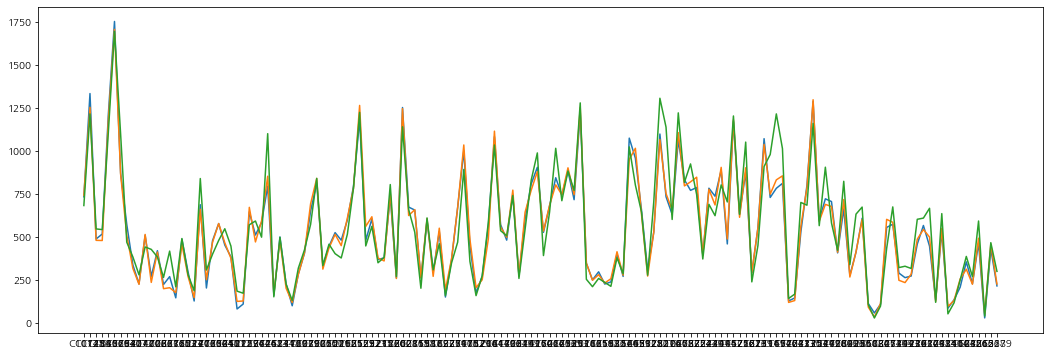

,code,num_x,num_y,danji_score,sub_score
6,C1794,871.263196,865.106495,1098.0,232.893505
11,C1006,270.551506,235.987350,428.0,192.012650
14,C2676,269.430105,205.057131,418.0,212.942869
19,C2411,687.737520,661.304019,840.0,178.695981
27,C1294,646.038741,672.461903,571.0,101.461903
28,C1772,511.633806,471.294860,593.0,121.705140
30,C1152,796.212447,853.512212,1101.0,247.487788
37,C1721,650.740601,693.323437,573.0,120.323437
41,C1071,525.523973,515.449484,403.0,112.449484
46,C1297,480.569185,561.576051,448.0,113.576051


In [75]:
import matplotlib.pyplot as plt


best_score = pd.read_csv('./result/result6_3.csv')
danji_score = new_test['단지내주차면수'].reset_index(drop=True)
current_score = pd.read_csv('./result/result8_2.csv')
print(mean_absolute_error(danji_score, current_score['num']))

plt.figure(figsize=(18,6))
plt.plot(best_score['code'], best_score['num'])
plt.plot(current_score['code'], current_score['num'])
plt.plot(best_score['code'], danji_score)
plt.show()

merge_score = best_score.merge(current_score, on='code')
merge_score['danji_score'] = danji_score
merge_score['sub_score'] = np.abs(merge_score['num_y'] - merge_score['danji_score'])
merge_score[merge_score['sub_score'] >= 100]